In [1]:
import pandas as pd
training = pd.read_csv('training.csv')
test = pd.read_csv('test.csv')
training.head()

,article_number,article_words,topic
0,1,"open,absent,cent,cent,cent,stock,inflow,rate,k...",FOREX MARKETS
1,2,"morn,stead,end,end,day,day,day,patch,patch,pat...",MONEY MARKETS
2,3,"socc,socc,world,world,recent,law,fifa,fifa,fif...",SPORTS
3,4,"open,forint,forint,forint,forint,cent,cent,ste...",FOREX MARKETS
4,5,"morn,complet,weekend,minut,minut,minut,arrow,d...",IRRELEVANT


In [2]:
from io import StringIO
col = ['topic', 'article_words']
training = training[col]
training[pd.notnull(training['article_words'])]

training.columns = ['topic', 'article_words']

training['category_id'] = training['topic'].factorize()[0]
category_id_training = training[['topic', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_training.values)
id_to_category = dict(category_id_training[['category_id', 'topic']].values)
training.head()

,topic,article_words,category_id
0,FOREX MARKETS,"open,absent,cent,cent,cent,stock,inflow,rate,k...",0
1,MONEY MARKETS,"morn,stead,end,end,day,day,day,patch,patch,pat...",1
2,SPORTS,"socc,socc,world,world,recent,law,fifa,fifa,fif...",2
3,FOREX MARKETS,"open,forint,forint,forint,forint,cent,cent,ste...",0
4,IRRELEVANT,"morn,complet,weekend,minut,minut,minut,arrow,d...",3


In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,6))
training.groupby('topic').article_words.count().plot.bar(ylim=0)
plt.show()

<Figure size 800x600 with 1 Axes>

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf = True, min_df=5, encoding='latin-1', ngram_range=(1,2), stop_words='english')

features = tfidf.fit_transform(training.article_words).toarray()
labels = training.category_id
features.shape

(9500, 37458)

In [5]:
from sklearn.feature_selection import chi2
import numpy as np

N=2
for topic, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(topic))
    print("  .Most correlated unigrams:\n. {}".format('\n.'.join(unigrams[-N:])))
    print("  .Most correlated bigrams:\n. {}".format('\n.'.join(bigrams[-N:])))

# 'ARTS CULTURE ENTERTAINMENT':
  .Most correlated unigrams:
. music
.film
  .Most correlated bigrams:
. art art
.film film
# 'BIOGRAPHIES PERSONALITIES PEOPLE':
  .Most correlated unigrams:
. hospit
.teret
  .Most correlated bigrams:
. teret teret
.hospit hospit
# 'DEFENCE':
  .Most correlated unigrams:
. milit
.nato
  .Most correlated bigrams:
. milit milit
.nato nato
# 'DOMESTIC MARKETS':
  .Most correlated unigrams:
. ton
.import
  .Most correlated bigrams:
. ton ton
.import import
# 'FOREX MARKETS':
  .Most correlated unigrams:
. currenc
.dollar
  .Most correlated bigrams:
. currenc currenc
.dollar dollar
# 'HEALTH':
  .Most correlated unigrams:
. smok
.diseas
  .Most correlated bigrams:
. tobacc tobacc
.diseas diseas
# 'IRRELEVANT':
  .Most correlated unigrams:
. net
.dollar
  .Most correlated bigrams:
. net net
.dollar dollar
# 'MONEY MARKETS':
  .Most correlated unigrams:
. rate
.bank
  .Most correlated bigrams:
. rate rate
.bank bank
# 'SCIENCE AND TECHNOLOGY':
  .Most correla

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(training['article_words'], training['topic'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

C:\Users\jaydo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jaydo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\jaydo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jaydo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\jaydo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default so

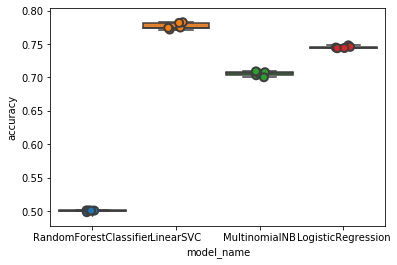

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(), 
    MultinomialNB(), 
    LogisticRegression(random_state=0)
]
CV = 5
cv_training = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_training = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_training)
sns.stripplot(x='model_name', y='accuracy', data=cv_training, size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [8]:
cv_training.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.776947
LogisticRegression        0.745263
MultinomialNB             0.705472
RandomForestClassifier    0.500422
Name: accuracy, dtype: float64

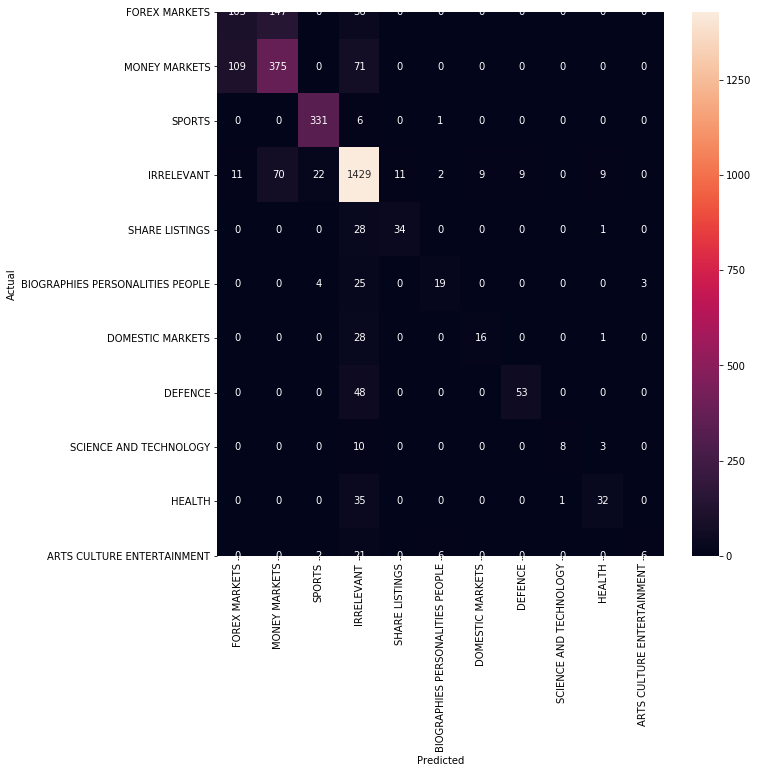

In [9]:
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, training.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=category_id_training.topic.values,yticklabels=category_id_training.topic.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [10]:
from IPython.display import display

for predicted in category_id_training.category_id:
    for actual in category_id_training.category_id:
        if predicted != actual and conf_mat[actual, predicted] > 10:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(training.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['topic', 'article_words']])
            print('')

'MONEY MARKETS' predicted as 'FOREX MARKETS' : 109 examples.


,topic,article_words
7748,MONEY MARKETS,"heavy,heavy,carac,cover,cent,cent,cent,recent,..."
4476,MONEY MARKETS,"comput,minist,cent,rate,rate,rate,calcul,compu..."
6823,MONEY MARKETS,"cpi,influ,strength,cent,absent,correct,correct..."
9015,MONEY MARKETS,"xau,cent,cent,fim,rate,gold,ecu,aud,sdr,fix,kg..."
3681,MONEY MARKETS,"open,colomb,colomb,drov,bocanegr,fall,fall,ind..."
...,...,...
7120,MONEY MARKETS,"open,open,open,heavy,juergen,downsid,relat,shr..."
6755,MONEY MARKETS,"morn,morn,stock,hope,elect,elect,sunday,rate,r..."
8904,MONEY MARKETS,"interim,quart,runaway,minist,anticip,strength,..."
5845,MONEY MARKETS,"rate,currenc,firm,germ,dem,volum,million,thurs..."



'IRRELEVANT' predicted as 'FOREX MARKETS' : 11 examples.


,topic,article_words
5033,IRRELEVANT,"stabl,minist,enabl,week,kurt,waigel,waigel,wai..."
2270,IRRELEVANT,"stabl,stabl,morn,minist,minist,minist,minist,c..."
5124,IRRELEVANT,"recov,mechan,early,early,launch,econom,econom,..."
1994,IRRELEVANT,"calm,televis,early,popul,congress,market,marke..."
2154,IRRELEVANT,"slash,slash,euro,euro,euro,euro,euro,euro,euro..."
2539,IRRELEVANT,"relat,hit,ing,strength,deprec,cent,cent,cent,d..."
6836,IRRELEVANT,"flow,open,open,stabl,cent,match,hope,diversif,..."
189,IRRELEVANT,"open,beat,stabl,strength,entry,stock,stock,sto..."
5081,IRRELEVANT,"xau,cent,cent,fim,rate,ecu,aud,sdr,fix,kgs,ltl..."
8088,IRRELEVANT,"juergen,stabl,stabl,stabl,gross,provid,holstei..."



'FOREX MARKETS' predicted as 'MONEY MARKETS' : 147 examples.


,topic,article_words
1995,FOREX MARKETS,"open,open,strength,strength,cent,cent,stead,fo..."
2839,FOREX MARKETS,"option,option,stabl,stabl,wish,cent,cent,cent,..."
2284,FOREX MARKETS,"open,downsid,hit,wary,half,cent,cent,gmt,match..."
2176,FOREX MARKETS,"sud,sud,morn,morn,correct,cent,gmt,gmt,rate,ra..."
9304,FOREX MARKETS,"rate,illeg,end,end,session,paul,real,real,real..."
...,...,...
2191,FOREX MARKETS,"frankfurt,frankfurt,fix,fix,tuesday,mark,mark,..."
500,FOREX MARKETS,"policem,natur,cent,cent,cent,cent,budget,defic..."
1433,FOREX MARKETS,"vilnius,fim,rate,ecu,fix,fix,friday,bank,peg,v..."
6041,FOREX MARKETS,"world,stock,stock,jan,jan,jan,jan,dax,jun,jun,..."



'IRRELEVANT' predicted as 'MONEY MARKETS' : 70 examples.


,topic,article_words
5417,IRRELEVANT,"cent,rate,contribut,barod,day,day,day,day,day,..."
5632,IRRELEVANT,"forint,rand,afric,south,rate,rate,ecu,ecu,fren..."
9133,IRRELEVANT,"open,open,open,tend,purchas,sa,cent,cent,cent,..."
1941,IRRELEVANT,"ist,citibank,centur,rate,contribut,contribut,d..."
2983,IRRELEVANT,"open,minist,minist,cent,cent,cent,nomin,nomin,..."
...,...,...
5553,IRRELEVANT,"purchas,americ,fed,fed,reserv,reserv,bank,dec,..."
6885,IRRELEVANT,"oct,bond,dollar,dollar,gbp,jpy,canad,canad,can..."
5541,IRRELEVANT,"ernest,samp,preview,preview,colomb,colomb,abro..."
8307,IRRELEVANT,"open,tend,relat,minist,publ,cent,cent,cent,exc..."



'IRRELEVANT' predicted as 'SPORTS' : 22 examples.


,topic,article_words
888,IRRELEVANT,"divid,socc,cup,cup,qualif,match,st,st,french,f..."
3774,IRRELEVANT,"worrel,stump,length,hit,morn,shivnarin,inn,ens..."
5474,IRRELEVANT,"socc,beat,beat,beat,vladislav,world,cup,ten,qu..."
1726,IRRELEVANT,"sean,hope,notch,tremblay,scor,scor,scor,scor,s..."
4254,IRRELEVANT,"ensur,match,match,sunday,acb,acb,acb,count,rec..."
7816,IRRELEVANT,"stockton,davy,davy,cup,seek,recent,scor,sugges..."
1218,IRRELEVANT,"eva,gross,gross,world,world,world,world,galin,..."
5700,IRRELEVANT,"afric,afric,afric,afric,afric,chil,hit,hit,wor..."
1223,IRRELEVANT,"ten,organis,organis,court,court,court,court,co..."
2828,IRRELEVANT,"miguel,colomb,colomb,riner,kevin,baff,baff,cyc..."



'FOREX MARKETS' predicted as 'IRRELEVANT' : 36 examples.


,topic,article_words
7608,FOREX MARKETS,"hit,debat,count,rule,initial,initial,initial,s..."
2898,FOREX MARKETS,"quart,quart,minus,minist,ten,ten,budget,march,..."
4387,FOREX MARKETS,"rate,rate,rate,rule,rule,rule,recent,recent,st..."
7950,FOREX MARKETS,"montgom,quart,beat,hit,strength,cent,cent,cent..."
3373,FOREX MARKETS,"open,research,thirt,gdp,gdp,stabl,stabl,stabl,..."
8716,FOREX MARKETS,"quart,publ,strength,declin,march,clu,confed,ra..."
4348,FOREX MARKETS,"davy,americ,gmt,huhtamak,ivo,fim,fim,fim,fim,f..."
6399,FOREX MARKETS,"congress,tuesday,heard,find,union,opinion,opin..."
6428,FOREX MARKETS,"pfennig,week,industr,day,friday,friday,output,..."
4942,FOREX MARKETS,"divid,purchas,purchas,wary,end,end,quot,govern..."



'MONEY MARKETS' predicted as 'IRRELEVANT' : 71 examples.


,topic,article_words
3861,MONEY MARKETS,"contrast,gross,minist,qualif,qualif,qualif,pub..."
7622,MONEY MARKETS,"open,open,stabl,world,minist,minist,minist,min..."
7006,MONEY MARKETS,"million,amount,amount,auction,weight,bombay,bi..."
2016,MONEY MARKETS,"option,option,option,figur,march,nomin,period,..."
5775,MONEY MARKETS,"research,steam,correct,gmt,declin,gradual,week..."
...,...,...
5165,MONEY MARKETS,"option,rand,rand,rand,rand,rand,afric,afric,mi..."
8161,MONEY MARKETS,"open,research,heavy,quart,quart,quart,quart,qu..."
4753,MONEY MARKETS,"open,stabl,southern,gross,minist,qualif,cent,c..."
2311,MONEY MARKETS,"research,soon,soon,natur,minist,cent,abroad,re..."



'SHARE LISTINGS' predicted as 'IRRELEVANT' : 28 examples.


,topic,article_words
3335,SHARE LISTINGS,"sa,regist,regist,case,south,americ,stock,stock..."
8521,SHARE LISTINGS,"montgom,term,million,million,corp,corp,estimat..."
7776,SHARE LISTINGS,"stock,stock,complet,term,held,fhs,fhs,stat,mil..."
1868,SHARE LISTINGS,"div,div,rand,sa,sa,sa,cts,cts,attrib,attrib,pa..."
5038,SHARE LISTINGS,"quart,quart,stock,stock,stock,prefer,prefer,pe..."
6138,SHARE LISTINGS,"world,comput,shap,stock,birmingham,design,end,..."
8867,SHARE LISTINGS,"cent,gmt,touch,stock,bat,issu,issu,issu,indust..."
5722,SHARE LISTINGS,"agro,group,unit,unit,unit,unit,stat,stat,pape,..."
6153,SHARE LISTINGS,"group,pipe,million,consolid,cowen,offer,offer,..."
9436,SHARE LISTINGS,"divid,rand,afric,afric,afric,afric,afric,south..."



'BIOGRAPHIES PERSONALITIES PEOPLE' predicted as 'IRRELEVANT' : 25 examples.


,topic,article_words
974,BIOGRAPHIES PERSONALITIES PEOPLE,"flow,minist,minist,minist,qualif,cent,elect,co..."
8636,BIOGRAPHIES PERSONALITIES PEOPLE,"germany,waff,world,lightn,bold,unity,unity,uni..."
5228,BIOGRAPHIES PERSONALITIES PEOPLE,"debat,assign,foregon,rule,rule,boycot,assembl,..."
635,BIOGRAPHIES PERSONALITIES PEOPLE,"pape,pape,world,rate,mock,debat,debat,daily,am..."
5160,BIOGRAPHIES PERSONALITIES PEOPLE,"flow,afric,weather,weather,southern,southern,w..."
2521,BIOGRAPHIES PERSONALITIES PEOPLE,"minist,minist,minist,minist,media,media,declin..."
2643,BIOGRAPHIES PERSONALITIES PEOPLE,"lalons,divid,constitu,laud,minist,minist,minis..."
7334,BIOGRAPHIES PERSONALITIES PEOPLE,"graft,glaucom,glaucom,boast,court,court,court,..."
9488,BIOGRAPHIES PERSONALITIES PEOPLE,"karel,glad,cent,resign,city,stat,nativ,quot,pr..."
9,BIOGRAPHIES PERSONALITIES PEOPLE,"queen,queen,park,hit,minist,minist,minist,mini..."



'DOMESTIC MARKETS' predicted as 'IRRELEVANT' : 28 examples.


,topic,article_words
6164,DOMESTIC MARKETS,"tend,afric,ensur,ensur,payment,prefer,rule,rul..."
6365,DOMESTIC MARKETS,"option,option,purchas,purchas,purchas,basf,pro..."
1421,DOMESTIC MARKETS,"minist,deficit,figur,figur,declin,rice,rice,ri..."
4183,DOMESTIC MARKETS,"metal,metal,metal,nkk,big,chin,chin,chin,chin,..."
4234,DOMESTIC MARKETS,"world,cover,cover,rule,access,eu,eu,quot,quot,..."
1082,DOMESTIC MARKETS,"purchas,purchas,purchas,purchas,carg,main,cent..."
2930,DOMESTIC MARKETS,"research,bomb,half,cent,cent,kk,centur,sekiyu,..."
6163,DOMESTIC MARKETS,"divid,stabl,southern,world,minist,minist,half,..."
3341,DOMESTIC MARKETS,"donor,world,minist,minist,provid,koiral,grant,..."
1112,DOMESTIC MARKETS,"purchas,minist,contribut,bat,bat,bat,bat,bat,b..."



'DEFENCE' predicted as 'IRRELEVANT' : 48 examples.


,topic,article_words
6067,DEFENCE,"yalu,yalu,case,south,south,south,south,south,s..."
841,DEFENCE,"provid,sink,debat,estimat,sunday,weekend,chemi..."
5972,DEFENCE,"tend,open,open,open,purchas,colomb,colomb,narc..."
5283,DEFENCE,"shaft,bomb,bomb,bomb,bomb,hope,congress,built,..."
9267,DEFENCE,"minist,minist,investig,textil,textil,cloth,cas..."
2686,DEFENCE,"bomb,bomb,bomb,bomb,bomb,bomb,bomb,congress,co..."
8598,DEFENCE,"open,ambassador,provid,minist,minist,minist,ce..."
2602,DEFENCE,"hundr,hope,sir,sir,debat,corrupt,rule,south,ev..."
8466,DEFENCE,"karel,minist,minist,minist,budget,interfax,int..."
5500,DEFENCE,"americ,americ,sunday,sunday,weekend,term,group..."



'HEALTH' predicted as 'IRRELEVANT' : 35 examples.


,topic,article_words
2631,HEALTH,"tend,femal,enriqu,valient,disord,disord,case,s..."
2104,HEALTH,"provid,world,strict,americ,robe,robe,drank,kin..."
1240,HEALTH,"engineer,count,rule,initial,americ,comment,cou..."
7907,HEALTH,"research,research,research,mad,march,week,week..."
7414,HEALTH,"davy,relat,main,suing,world,minist,cloth,inund..."
8522,HEALTH,"hit,salad,world,world,cent,americ,gambl,gambl,..."
5175,HEALTH,"con,hope,hope,world,rule,americ,massachuset,co..."
4001,HEALTH,"flow,accord,accord,accord,payment,payment,paym..."
3170,HEALTH,"hear,administ,court,court,court,cover,congress..."
7797,HEALTH,"administ,whit,panel,stat,friday,charg,top,huma..."



'ARTS CULTURE ENTERTAINMENT' predicted as 'IRRELEVANT' : 21 examples.


,topic,article_words
8760,ARTS CULTURE ENTERTAINMENT,"sweat,weather,lamp,regist,shap,leather,bathrob..."
1984,ARTS CULTURE ENTERTAINMENT,"open,minist,minist,influ,cover,cent,distribut,..."
4126,ARTS CULTURE ENTERTAINMENT,"sellout,declar,organis,ticket,ticket,cancel,fr..."
4244,ARTS CULTURE ENTERTAINMENT,"shap,doubloon,centur,centur,yeah,americ,busy,m..."
5639,ARTS CULTURE ENTERTAINMENT,"telecom,telecom,telecom,world,world,world,worl..."
1332,ARTS CULTURE ENTERTAINMENT,"heavy,revolut,rushdie,rushdie,rushdie,rushdie,..."
2784,ARTS CULTURE ENTERTAINMENT,"recent,fine,tune,city,entitl,play,bucaram,buca..."
5584,ARTS CULTURE ENTERTAINMENT,"starkey,distribut,resign,dreamwork,satel,speci..."
3202,ARTS CULTURE ENTERTAINMENT,"park,relat,relat,merid,main,world,world,world,..."
7167,ARTS CULTURE ENTERTAINMENT,"door,contin,main,entry,entry,sunday,sunday,res..."



'IRRELEVANT' predicted as 'SHARE LISTINGS' : 11 examples.


,topic,article_words
1835,IRRELEVANT,"issu,estimat,note,shar,york,rang,rang,newsdesk..."
8397,IRRELEVANT,"tateh,tateh,tateh,tateh,tateh,tse,media,media,..."
1480,IRRELEVANT,"stock,stock,million,million,threshold,scal,sca..."
5357,IRRELEVANT,"hambrecht,quist,million,million,even,estimat,n..."
7962,IRRELEVANT,"southern,stock,http,www,chin,chin,hk97,city,en..."
9173,IRRELEVANT,"open,door,gross,provid,provid,regist,regist,ha..."
7351,IRRELEVANT,"minist,provid,qualif,stock,stock,apply,apply,f..."
8905,IRRELEVANT,"open,open,kevin,stock,businessm,chin,issu,brig..."
3515,IRRELEVANT,"southern,chin,chin,issu,issu,group,proceed,pro..."
3365,IRRELEVANT,"sa,metal,main,oversubscrib,stat,offer,offer,po..."


In [12]:
model.fit(features, labels)

N = 2
for topic, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(topic))
    print("  . Top unigrams:\n .{}".format('\n. '.join(unigrams)))
    print("  . Top bigrams:\n .{}".format('\n. '.join(bigrams)))

# 'ARTS CULTURE ENTERTAINMENT':
  . Top unigrams:
 .film
. cultur
  . Top bigrams:
 .art art
. film film
# 'BIOGRAPHIES PERSONALITIES PEOPLE':
  . Top unigrams:
 .fami
. hospit
  . Top bigrams:
 .hospit hospit
. fami fami
# 'DEFENCE':
  . Top unigrams:
 .milit
. defend
  . Top bigrams:
 .forc forc
. milit milit
# 'DOMESTIC MARKETS':
  . Top unigrams:
 .import
. tariff
  . Top bigrams:
 .import import
. tariff tariff
# 'FOREX MARKETS':
  . Top unigrams:
 .dollar
. forex
  . Top bigrams:
 .dollar dollar
. deviat deviat
# 'HEALTH':
  . Top unigrams:
 .health
. patient
  . Top bigrams:
 .health health
. patient patient
# 'IRRELEVANT':
  . Top unigrams:
 .index
. plant
  . Top bigrams:
 .term day
. credit credit
# 'MONEY MARKETS':
  . Top unigrams:
 .bank
. treasur
  . Top bigrams:
 .short short
. foreign wednesday
# 'SCIENCE AND TECHNOLOGY':
  . Top unigrams:
 .scient
. spac
  . Top bigrams:
 .scient scient
. spac spac
# 'SHARE LISTINGS':
  . Top unigrams:
 .list
. suspend
  . Top bigrams:

In [13]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=training['topic'].unique()))

                                  precision    recall  f1-score   support

                   FOREX MARKETS       0.46      0.36      0.40       286
                   MONEY MARKETS       0.63      0.68      0.65       555
                          SPORTS       0.92      0.98      0.95       338
                      IRRELEVANT       0.82      0.91      0.86      1572
                  SHARE LISTINGS       0.76      0.54      0.63        63
BIOGRAPHIES PERSONALITIES PEOPLE       0.68      0.37      0.48        51
                DOMESTIC MARKETS       0.64      0.36      0.46        45
                         DEFENCE       0.85      0.52      0.65       101
          SCIENCE AND TECHNOLOGY       0.89      0.38      0.53        21
                          HEALTH       0.70      0.47      0.56        68
      ARTS CULTURE ENTERTAINMENT       0.67      0.17      0.27        35

                        accuracy                           0.77      3135
                       macro avg    